# Pengambilan Data

In [1]:
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

In [2]:
import twitter_credentials
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

In [4]:
# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

In [5]:
# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)

In [6]:
# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
      
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                       tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

In [7]:
 class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
         
    def clean_tweet(self, tweet):
    
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w +:\/\/ \S +)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        # analysis = analysis.translate(from_lang = 'in',to='en')

        if analysis.sentiment.polarity > 0:
            return "Positif"
        elif analysis.sentiment.polarity == 0:
            return "Netral"
        else:
            return "Negatif"
        
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        
        df['id'] = np.array([tweet.id_str for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['lang'] = np.array([tweet.lang for tweet in tweets])
        df['place'] = np.array([tweet.place for tweet in tweets ])
        

        return df

In [16]:
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    keyword = ["cryptocurrency"]
    api = twitter_client.get_twitter_client_api()
    tweets = api.search(keyword, count=100, lang = 'en')

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

    print(df)

                                               tweets                   id  \
0   South Sudan forges ‘unity government’ in bid t...  1236806036289466368   
1   Blistering and virtuosic, depth and wisdom... ...  1236806033466589184   
2   RT @cryptobrice: 🚨 $10 #BTC  &amp; 15.000 $CRT...  1236806027489705984   
3   RT @iTOKENZCrypto: Best damn thing I’ve read a...  1236806006568620034   
4   Another winner! Come to https://t.co/mLNM0cpPz...  1236805990604996609   
..                                                ...                  ...   
95  RT @USDGtoken: ⚠️USDG airdrop is going finish ...  1236803802373619712   
96  RT @Schuldensuehner: #Bitcoin slumps to $8,300...  1236803740042133509   
97  RT @affaritalia: I'm in the running to #win 10...  1236803726511407107   
98  RT @Schuldensuehner: #Bitcoin slumps to $8,300...  1236803623188742144   
99  RT @Energicrypto: Did you see #Energi featured...  1236803603156762624   

                  date               source lang place sentimen

# Preproses

In [17]:
def remove_punct(text):
  
    #hapus simbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub('rt @[^\s]+',' ', text)
    text = re.sub('@[^\s]+',' ',text)
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    #trim
    text = text.strip('\'"')
    text  = "".join([char for char in text if char not in string.punctuation])
    #text = re.sub('[0-9]+', '', text)

    return text

df['tweet_bersih'] = df['tweets'].apply(lambda x: remove_punct(x.lower()))

In [18]:
#--- REMOVE DUPLICATES
df = df.drop_duplicates(['tweet_bersih'])
df

,tweets,id,date,source,lang,place,sentiment,tweet_bersih
0,South Sudan forges ‘unity government’ in bid t...,1236806036289466368,2020-03-09 00:08:32,MEGNEW,en,None,Netral,south sudan forges unity government in bid to ...
1,"Blistering and virtuosic, depth and wisdom... ...",1236806033466589184,2020-03-09 00:08:31,MEGNEW,en,None,Netral,blistering and virtuosic depth and wisdom wome...
2,RT @cryptobrice: 🚨 $10 #BTC &amp; 15.000 $CRT...,1236806027489705984,2020-03-09 00:08:30,Twitter Web App,en,None,Positif,10 btc amp 15000 crtc giveaway follow likert ...
3,RT @iTOKENZCrypto: Best damn thing I’ve read a...,1236806006568620034,2020-03-09 00:08:25,Twitter for Android,en,None,Positif,best damn thing i ve read all day cryptocurre...
4,Another winner! Come to https://t.co/mLNM0cpPz...,1236805990604996609,2020-03-09 00:08:21,Twitter Web App,en,None,Positif,another winner come to and join the fun headin...
...,...,...,...,...,...,...,...,...
92,BitMex Large Activity:\n🔴 #XBTUSD Shorts Worth...,1236803899559993344,2020-03-09 00:00:03,CryptoMeter,en,None,Positif,bitmex large activity xbtusd shorts worth 1802...
93,If you had bought 1000 #EURO of #BITCOIN the 1...,1236803886968602624,2020-03-09 00:00:00,shohk_com,en,None,Netral,if you had bought 1000 euro of bitcoin the 100...
94,Check out the newest ROUNDTABLE:\nCryptocurren...,1236803882451427328,2020-03-08 23:59:58,Twitter Web App,en,None,Positif,check out the newest roundtable cryptocurrency...
95,RT @USDGtoken: ⚠️USDG airdrop is going finish ...,1236803802373619712,2020-03-08 23:59:39,Twitter for Android,en,None,Netral,usdg airdrop is going finish on march 25 we r...


In [19]:
df.to_excel("Data Tanggal 9 pagi (cryptocurrency).xlsx")
df.to_csv("Data Tanggal 9 pagi (cryptocurrency).csv")

# Visualisasi Data

In [22]:
df = pd.read_excel('Data Tanggal 9 pagi (bitcoin).xlsx',header=0,encoding = 'unicode_escape', index_col=0)
df.count

<bound method DataFrame.count of                                                tweets                   id  \
0            @CokePokes Tell him to pay ya in bitcoin  1236805774031990785   
1   RT @ignxred: Ok last time i try to sell these ...  1236805772916535297   
2   RT @CryptoLits: 🧪🦠💉💊Can $AMB #Ambrosus contrib...  1236805770026471424   
3                           @JimfromBC Bitcoin? Fuck,  1236805764553093121   
4   RT @stacyherbert: Bitcoin is out performing oi...  1236805763428954112   
..                                                ...                  ...   
93  @Witty_Crypto @thebryman530 Took kids to new J...  1236805338042695682   
94  #bitcoin history teaches us:\n\nBig dump =&gt;...  1236805329394024448   
95  @spectatorindex #Bitcoin showing correlation w...  1236805320858636290   
97  Full blown collapse - oil markets tanking, SPY...  1236805313317294080   
99  @GemmaActon @CommBank Safe to say investment m...  1236805300574998528   

                  date        

In [23]:
df = df.drop_duplicates(['tweet_bersih'])

In [24]:
df_positif = df[df['sentiment'] == 'Positif']
df_negatif = df[df['sentiment'] == 'Negatif']
df_netral = df[df['sentiment'] == 'Netral']
df_negatif

,tweets,id,date,source,lang,place,sentiment,tweet_bersih
3,"@JimfromBC Bitcoin? Fuck,",1236805764553093121,2020-03-09 00:07:27,Twitter for iPhone,en,NaN,Negatif,bitcoin fuck
9,RT @kennagq: Bissaka probably uses Bitcoin \n\...,1236805740536397826,2020-03-09 00:07:21,Twitter for iPhone,en,NaN,Negatif,bissaka probably uses bitcoin cos hes making ...
20,Is Twitter Helping Justin Sun and Other Crypto...,1236805673406681088,2020-03-09 00:07:05,TwinyBots,en,NaN,Negatif,is twitter helping justin sun and other crypto...
22,All that money in Bitcoin is coming right into...,1236805669333995520,2020-03-09 00:07:04,Twitter for Android,en,NaN,Negatif,all that money in bitcoin is coming right into...
23,"Bitcoin Taps $8,000 as Violent Sell-Off Rocks ...",1236805665516969984,2020-03-09 00:07:04,Wordpress same post app,en,NaN,Negatif,bitcoin taps 8000 as violent selloff rocks sam...
24,#Bitcoin is down 7.56% for the day.\n$BTC is c...,1236805660924432384,2020-03-09 00:07:02,Twitter Web App,en,NaN,Negatif,bitcoin is down 756 for the day btc is current...
42,"@HsakaTrades Who to blame? Exchange, wallet &a...",1236805557597560833,2020-03-09 00:06:38,Twitter for iPhone,en,NaN,Negatif,who to blame exchange wallet amp scam that ne...
60,RT @Excellion: ✅ Fiat still printed out of thi...,1236805486860787712,2020-03-09 00:06:21,Twitter Web App,en,NaN,Negatif,fiat still printed out of thin air negative i...
61,RT @cryptowhale: The USA is in for some dark t...,1236805480422551552,2020-03-09 00:06:19,Twitter for Android,en,NaN,Negatif,the usa is in for some dark times opec colla...
72,RT @gaborgurbacs: #Bitcoin has dropped ~6.5% o...,1236805438496104448,2020-03-09 00:06:09,Twitter for iPhone,en,NaN,Negatif,bitcoin has dropped 65 over the past day sund...


In [25]:
sentimen_count = df['sentiment'].value_counts()
sentimen_count

Netral     31
Positif    29
Negatif    12
Name: sentiment, dtype: int64

In [86]:
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from stop_words import get_stop_words

stopwords = get_stop_words('english')
stopwords_add = list()
stopwords_add = input("Apa?")
stopwords += stopwords_add

Apa?bitcoin


In [87]:
words_positif = ' '.join(df_positif['tweet_bersih'])
words_negatif = ' '.join(df_negatif['tweet_bersih'])
words_netral = ' '.join(df_netral['tweet_bersih'])

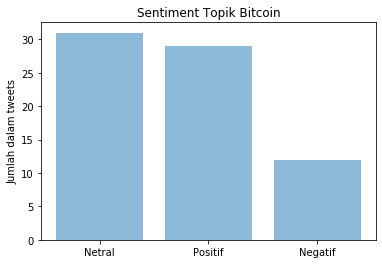

In [88]:
objects = sentimen_count.index
y_pos = np.arange(len(objects))
performance = sentimen_count
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Jumlah dalam tweets')
plt.title('Sentiment Topik Bitcoin')
 
plt.show()

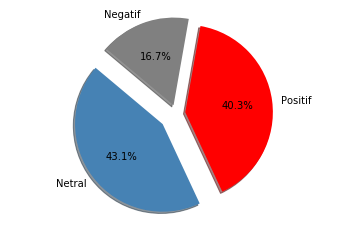

In [89]:
labels = sentimen_count.index
sizes = sentimen_count
colors = ['steelblue', 'red', 'gray']
explode = (0.2, 0.1, 0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [90]:
mask = np.array(Image.open("shape.png"))
wordcloud = WordCloud(stopwords = stopwords, background_color='white', height = 2000, width = 2000, max_words = 50, font_path='lucidasansdemibold.ttf', prefer_horizontal=0.70, colormap='winter', mask=mask).generate(words_positif)

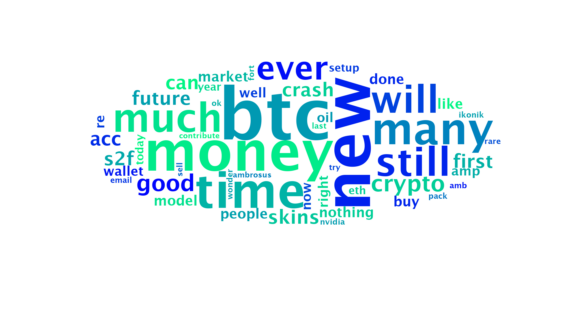

In [91]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.ion()
plt.show()

In [61]:
# Save the image
wordcloud.to_file("wordcloud_positif.png")

In [68]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white', height = 2000, width = 2000,
                      max_words = 50, font_path='lucidasansdemibold.ttf', prefer_horizontal=0.70, colormap='winter', mask=mask).generate(words_negatif)

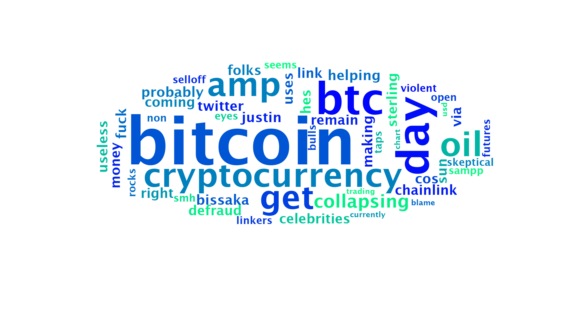

In [69]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.ion()
plt.show()

In [65]:
# Save the image
wordcloud.to_file("wordcloud_negatif.png")

In [70]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white', height = 2000, width = 2000,
                      max_words = 50, font_path='lucidasansdemibold.ttf', prefer_horizontal=0.70, colormap='winter', mask=mask).generate(words_netral)

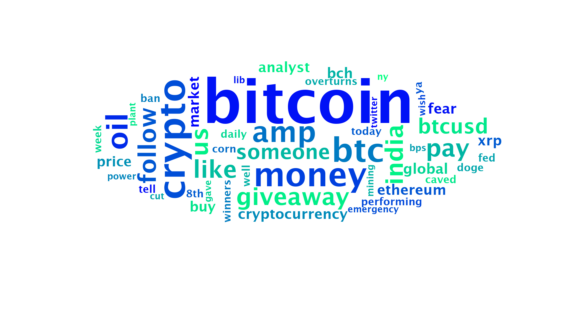

In [71]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.ion()
plt.show()

In [32]:
# Save the image
wordcloud.to_file("wordcloud_netral.png")